In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTMSNForImageClassification, ViTImageProcessor
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
import random

G:\Anaconda\envs\MP_Siamese\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Logging and device configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
SAVE_DIR = "models"
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5

In [4]:
# Saving and loading utilities
def save_model(model, path, optimizer=None, epoch=None, loss=None):
    save_dict = {
        'model_state_dict': model.state_dict(),
    }
    if optimizer:
        save_dict['optimizer_state_dict'] = optimizer.state_dict()
    if epoch is not None:
        save_dict['epoch'] = epoch
    if loss is not None:
        save_dict['loss'] = loss
    
    torch.save(save_dict, path)
    logger.info(f"Model saved to {path}")

def load_model(model, path):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        logger.info(f"Model loaded from {path}")
        return True

In [5]:
class KvasirDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.processor = ViTImageProcessor.from_pretrained('facebook/vit-msn-small', do_rescale=False)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
                img = img.numpy()
            inputs = self.processor(images=img, return_tensors="pt")
            return inputs['pixel_values'].squeeze(), self.labels[idx]
        except Exception as e:
            logger.error(f"Error loading image {self.image_paths[idx]}: {str(e)}")
            raise
            
def prepare_data(data_dir):
    try:
        classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        if 'polyps' in classes:
            classes.remove('polyps')
        print(f"Number of classes: {len(classes)}")
        image_paths = []
        labels = []
        
        for idx, class_name in enumerate(classes):
            class_path = os.path.join(data_dir, class_name)
            class_images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                          if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            image_paths.extend(class_images)
            labels.extend([idx] * len(class_images))
        
        logger.info(f"Found {len(image_paths)} images across {len(classes)} classes")
        return train_test_split(image_paths, labels, test_size=0.2, random_state=42)
    
    except Exception as e:
        logger.error(f"Error preparing data: {str(e)}")
        raise


In [6]:
class DatasetManager:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        
    def stratified_split(self, test_size=80):
        # Collect all image paths and labels
        all_image_paths = {}
        for class_name in self.classes:
            class_path = os.path.join(self.data_dir, class_name)
            class_images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                            if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_image_paths[class_name] = class_images
        
        # Stratified test set selection
        test_paths = []
        test_labels = []
        remaining_paths = {}
        
        for idx, (class_name, images) in enumerate(all_image_paths.items()):
            # Calculate test images per class (proportional to 100 total)
            class_test_size = max(1, test_size // len(self.classes))
            
            # Randomly select test images
            test_class_images = random.sample(images, min(class_test_size, len(images)))
            
            # Add to test set
            test_paths.extend(test_class_images)
            test_labels.extend([idx] * len(test_class_images))
            
            # Remove test images from original set
            remaining_images = [img for img in images if img not in test_class_images]
            remaining_paths[class_name] = remaining_images
        
        # Separate polyps class
        polyps_paths = all_image_paths.get('polyps', [])
        
        # Prepare remaining paths for train/val split
        all_remaining_paths = []
        all_remaining_labels = []
        for class_name, paths in remaining_paths.items():
            if class_name != 'polyps':
                all_remaining_paths.extend(paths)
                all_remaining_labels.extend([self.classes.index(class_name)] * len(paths))
        
        # Split remaining images into train and validation
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            all_remaining_paths, all_remaining_labels, test_size=0.2, random_state=42
        )
        
        return {
            'test_paths': test_paths,
            'test_labels': test_labels,
            'train_paths': train_paths,
            'train_labels': train_labels,
            'val_paths': val_paths,
            'val_labels': val_labels,
            'polyps_paths': polyps_paths
        }


In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [8]:
# Dataset directory
DATA_DIR = r"..\Datasets\kvasir-dataset-v2"
# Initialize dataset manager
dataset_manager = DatasetManager(DATA_DIR)
# Perform stratified splitting
split_data = dataset_manager.stratified_split()

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self, num_classes=None):
        super(SiameseNetwork, self).__init__()
        self.vit = ViTMSNForImageClassification.from_pretrained('facebook/vit-msn-small')
        
        # Dynamically determine number of classes if not provided
        if num_classes is None:
            num_classes = len(set(split_data['train_labels']))
        
        self.fc = nn.Linear(self.vit.config.hidden_size, num_classes)
        
    def forward_one(self, x):
        outputs = self.vit(x, output_hidden_states=True)
        return self.fc(outputs.hidden_states[-1][:, 0])
        
    def forward(self, x1, x2=None):
        output1 = self.forward_one(x1)
        if x2 is not None:
            output2 = self.forward_one(x2)
            return output1, output2
        return output1

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [10]:
    # Testing function
def test_model(model, test_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
        accuracy = 100. * correct / total
        logger.info(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

In [11]:
def run_few_shot_experiments(model, test_loader, polyps_paths, max_shots=10):
    results = []
    
    for shots in range(1, max_shots + 1):
        # Reset model and fine-tune
        fine_tuned_model = few_shot_fine_tuning(model, polyps_paths, num_shots=shots)
        
        # Test fine-tuned model
        test_accuracy = test_model(fine_tuned_model, test_loader)
        
        results.append({
            'Shots': shots,
            'Accuracy': test_accuracy
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save to CSV
    results_df.to_csv(os.path.join(SAVE_DIR, 'few_shot_results.csv'), index=False)
    
    # Plot line chart
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Shots'], results_df['Accuracy'], marker='o')
    plt.title('Few-Shot Learning: Model Performance')
    plt.xlabel('Number of Shots')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'few_shot_performance.png'))
    plt.close()
    
    return results_df

In [12]:
def train_model(model, train_loader, val_loader, save_path, num_epochs=10):
    # Check if model already exists
    if load_model(model, save_path):
        return model
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_model(model, save_path, optimizer, epoch, best_val_loss)
    
    return model

def few_shot_fine_tuning(model, polyps_paths, num_shots=5):
    fine_tune_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    # Prepare save path
    save_path = f"models/fine_tuned_{num_shots}.pth"
    
    # Check if fine-tuned model exists
    if load_model(model, save_path):
        return model
    
    # Select a small number of polyps images
    selected_polyps = random.sample(polyps_paths, min(num_shots, len(polyps_paths)))
    
    # Create a custom dataset for fine-tuning
    fine_tune_dataset = KvasirDataset(selected_polyps, [0]*len(selected_polyps), fine_tune_transform)
    fine_tune_loader = DataLoader(fine_tune_dataset, batch_size=num_shots, shuffle=True)
    
    # Prepare for fine-tuning
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    # Fine-tuning loop
    for _ in range(10):  # Few iterations for few-shot learning
        for images, _ in fine_tune_loader:
            images = images.to(DEVICE)
            labels = torch.zeros(images.size(0), dtype=torch.long).to(DEVICE)  # Polyps class
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Save fine-tuned model
    save_model(model, save_path)
    
    return model

In [13]:
!pip install pandas matplotlib


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
def main():  
    # Create datasets
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    # Prepare datasets
    train_dataset = KvasirDataset(split_data['train_paths'], split_data['train_labels'], transform)
    val_dataset = KvasirDataset(split_data['val_paths'], split_data['val_labels'], transform)
    test_dataset = KvasirDataset(split_data['test_paths'], split_data['test_labels'], transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    # Model initialization and training
    model = SiameseNetwork().to(DEVICE)
    early_stopping = EarlyStopping(patience=5)
    os.makedirs(SAVE_DIR, exist_ok=True)

    # Training loop
    train_model(model, train_loader, val_loader, "models/main_model.pth")   
    
    # Perform testing
    test_accuracy = test_model(model, test_loader)
    
    # Few-shot fine-tuning with polyps
    # Run few-shot experiments
    few_shot_results = run_few_shot_experiments(
        model, 
        test_loader, 
        split_data['polyps_paths'], 
        max_shots=10
    )
    
    # Print results
    print(few_shot_results)

if __name__ == "__main__":
    main()

Some weights of ViTMSNForImageClassification were not initialized from the model checkpoint at facebook/vit-msn-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ninja\AppData\Local\Temp\ipykernel_29472\3008922499.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

   Shots  Accuracy
0      1     75.00
1      2     60.00
2      3     48.75
3      4     36.25
4      5     17.50
5      6     17.50
6      7     17.50
7      8     17.50
8      9     17.50
9     10     16.25


Quick way to visualize more of how the pre-processing works here. for easier step by step viewing I recreated the pre-processing from the hugginface pre-processor configuration. Additionally because the model does all the random masking while training and not while pre-processing, I recreated and example of this sort of masking so it can be easily shown bellow.

In [48]:
# ViT MSN Feature Extractor settings
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

def visualize_vit_preprocessing(dataset, idx, apply_masking=True, mask_percentage=70):
    try:
        # Load original image
        img = Image.open(dataset.image_paths[idx]).convert("RGB")
        print("Original Image:")
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        
        # Resize the image to 224x224
        resize_transform = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.BILINEAR)
        resized_img = resize_transform(img)
        print("Resized Image (224x224):")
        plt.imshow(resized_img)
        plt.axis("off")
        plt.show()
        
        # Convert to Tensor & Normalize
        preprocess_transform = transforms.Compose([
            transforms.ToTensor(),  
            transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)  
        ])
        tensor_img = preprocess_transform(resized_img)  
        print("Tensor Image (Normalized):")
        print(tensor_img) 
        plt.imshow(tensor_img.permute(1, 2, 0).numpy())  
        plt.axis("off")
        plt.show()
        
        # Apply random masking if requested
        if apply_masking:
            # Convert tensor back to numpy array for masking
            normalized_img = tensor_img.permute(1, 2, 0).numpy()
            
            # Create random mask
            mask = np.random.rand(IMAGE_SIZE, IMAGE_SIZE) < (mask_percentage / 100)
            mask = np.expand_dims(mask, axis=2)
            mask = np.repeat(mask, 3, axis=2)  # For RGB channels
            
            # Apply masking
            masked_img = normalized_img.copy()
            masked_img[mask] = 0
            
            # Display masked image
            print(f"Masked Image ({mask_percentage}% masked):")
            plt.figure()
            plt.imshow(masked_img)
            plt.axis("off")
            plt.show()
            
            # Show original and masked side by side for comparison
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(normalized_img)
            plt.title("Normalized Image")
            plt.axis("off")
            
            plt.subplot(1, 2, 2)
            plt.imshow(masked_img)
            plt.title(f"Masked Image ({mask_percentage}% masked)")
            plt.axis("off")
            
            plt.tight_layout()
            plt.show()
            
            # Convert masked image back to tensor if needed
            masked_tensor = torch.from_numpy(masked_img.transpose(2, 0, 1))
            return tensor_img, masked_tensor
        
        return tensor_img, None
            
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None

Original Image:


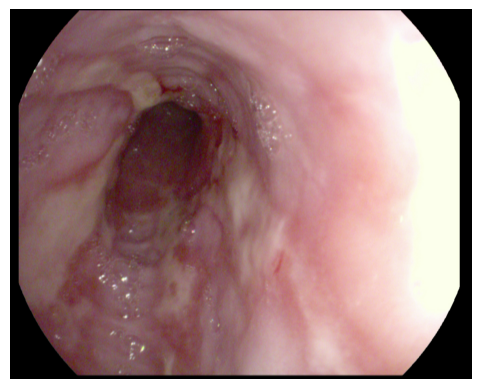

Resized Image (224x224):


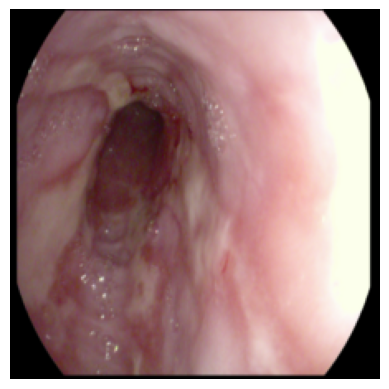

Tensor Image (Normalized):
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044,

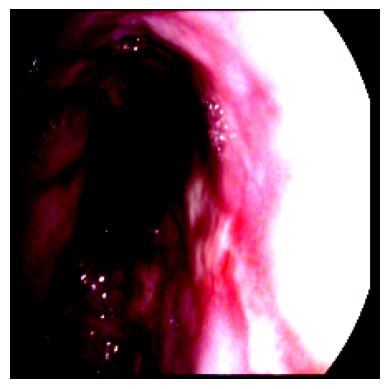

Masked Image (70% masked):


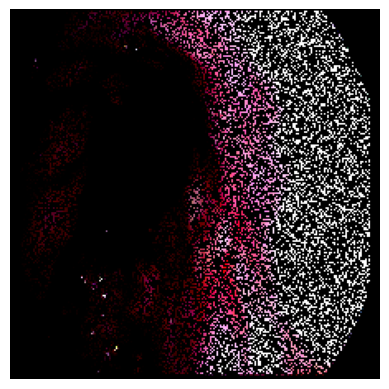

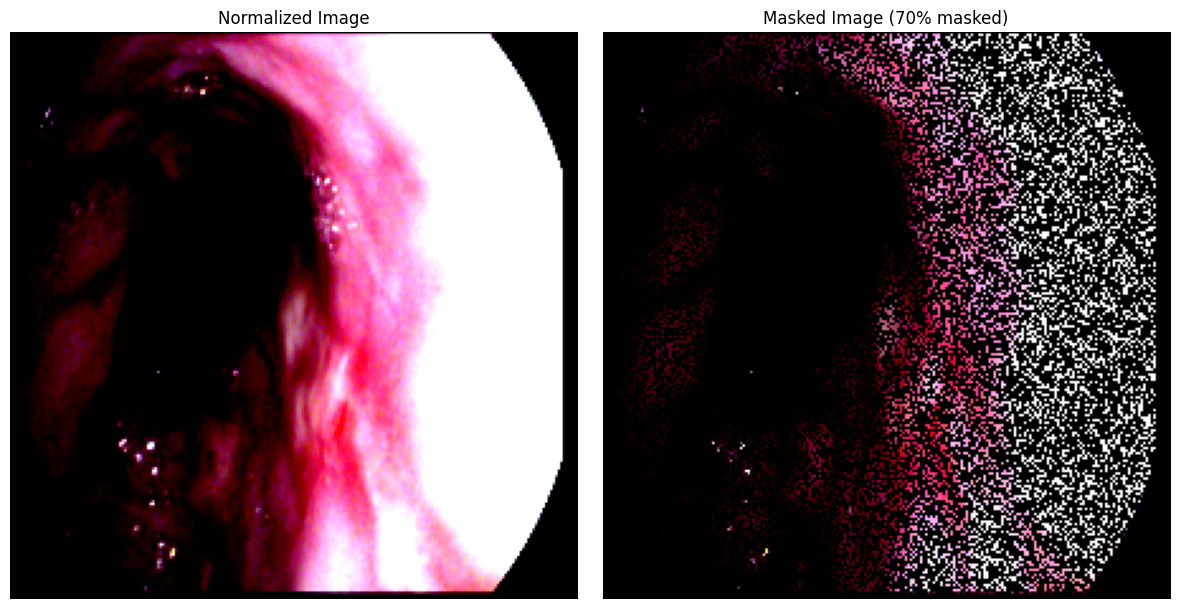

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [49]:
dataset = KvasirDataset(split_data['train_paths'], split_data['train_labels'], transform=None)
visualize_vit_preprocessing(dataset, 100)